## Libs

In [1]:
import pandas as pd
import numpy as np
import pickle 
import joblib
import sys

import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.compose import ColumnTransformer
from fast_ml.model_development import train_valid_test_split

from yellowbrick.classifier import confusion_matrix
from yellowbrick.classifier import ROCAUC

## Extraction

In [2]:
# path to read specific csv data
path = r'C:\Users\erico\Documents\projeto-churn\Telco-Customer-Churn\data\WA_Fn-UseC_-Telco-Customer-Churn.csv'
# config path scripts
sys.path.insert(0, r'C:\Users\erico\Documents\projeto-churn\Telco-Customer-Churn\scripts')

from extract_data import read_data

df = read_data(path)
df_copy = df.set_index(['customerID']).copy()
df_copy.drop(['gender','PhoneService'], inplace=True, axis=1)

# train, test and val split

In [3]:
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df_copy, target = 'Churn', train_size=0.8, valid_size=0.1, test_size=0.1)

print('X_train shape: ',X_train.shape)
print('y_train shape: ',y_train.shape)
print('X_valid shape: ',X_valid.shape)
print('y_valid shape: ',y_valid.shape)
print('X_test shape: ',X_test.shape)
print('y_test shape: ',y_test.shape)

X_train shape:  (5634, 17)
y_train shape:  (5634,)
X_valid shape:  (704, 17)
y_valid shape:  (704,)
X_test shape:  (705, 17)
y_test shape:  (705,)


# Persist split data

In [4]:
with open(r'C:\Users\erico\Documents\projeto-churn\Telco-Customer-Churn\data\X_train.pkl', 'wb') as f:
    pickle.dump(X_train, f)

with open(r'C:\Users\erico\Documents\projeto-churn\Telco-Customer-Churn\data\y_train.pkl', 'wb') as f:
    pickle.dump(y_train, f)

with open(r'C:\Users\erico\Documents\projeto-churn\Telco-Customer-Churn\data\X_valid.pkl', 'wb') as f:
    pickle.dump(X_valid, f)

with open(r'C:\Users\erico\Documents\projeto-churn\Telco-Customer-Churn\data\y_valid.pkl', 'wb') as f:
    pickle.dump(y_valid, f)

with open(r'C:\Users\erico\Documents\projeto-churn\Telco-Customer-Churn\data\X_test.pkl', 'wb') as f:
    pickle.dump(X_test, f)

with open(r'C:\Users\erico\Documents\projeto-churn\Telco-Customer-Churn\data\y_test.pkl', 'wb') as f:
    pickle.dump(y_test, f)

## Load - train, valid, test

In [5]:
with open(r'C:\Users\erico\Documents\projeto-churn\Telco-Customer-Churn\data\X_train.pkl', 'rb') as f:
    X_train = pickle.load(f)

with open(r'C:\Users\erico\Documents\projeto-churn\Telco-Customer-Churn\data\y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)

In [6]:
with open(r'C:\Users\erico\Documents\projeto-churn\Telco-Customer-Churn\data\X_valid.pkl', 'rb') as f:
    X_valid = pickle.load(f)

with open(r'C:\Users\erico\Documents\projeto-churn\Telco-Customer-Churn\data\y_valid.pkl', 'rb') as f:
    y_valid = pickle.load(f)

In [7]:
with open(r'C:\Users\erico\Documents\projeto-churn\Telco-Customer-Churn\data\X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)

with open(r'C:\Users\erico\Documents\projeto-churn\Telco-Customer-Churn\data\y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)

## Feature Selection

In [8]:
num_cols = df_copy.select_dtypes(include=['number']).columns.tolist()

In [9]:
num_cols

['tenure', 'MonthlyCharges', 'TotalCharges']

In [10]:
cat_cols = df_copy.select_dtypes(include=['object']).columns.tolist()[:-1]

In [11]:
cat_cols

['SeniorCitizen',
 'Partner',
 'Dependents',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

## Create Pipeline 

In [12]:
preprocessor = ColumnTransformer(
                                transformers=[
                                ('cat', ce.BinaryEncoder(), cat_cols), 
                                ('num', MinMaxScaler(), num_cols)
                                ], remainder="passthrough")

model = LogisticRegression(C=0.1,
                           random_state=42,
                           max_iter=300, 
                           class_weight="balanced")

model_pipe = Pipeline(steps = [('preprocessor',preprocessor),
                                ('model', model)])

In [13]:
model_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', TargetEncoder(),
                                                  ['SeniorCitizen', 'Partner',
                                                   'Dependents',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod']),
                                                 ('num', MinMaxScaler(),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges'])])),
                ('model',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    max_iter=300, random_state=42))])

## Training and Validate

In [14]:
# Encoder Target variables
le_Y = LabelEncoder()
y_train = le_Y.fit_transform(y_train)
y_valid = le_Y.transform(y_valid)
y_test = le_Y.transform(y_test)

Recall_CV:0.766 STD: 0.12, AUC: 0.751
Model:Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', TargetEncoder(),
                                                  ['SeniorCitizen', 'Partner',
                                                   'Dependents',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
               

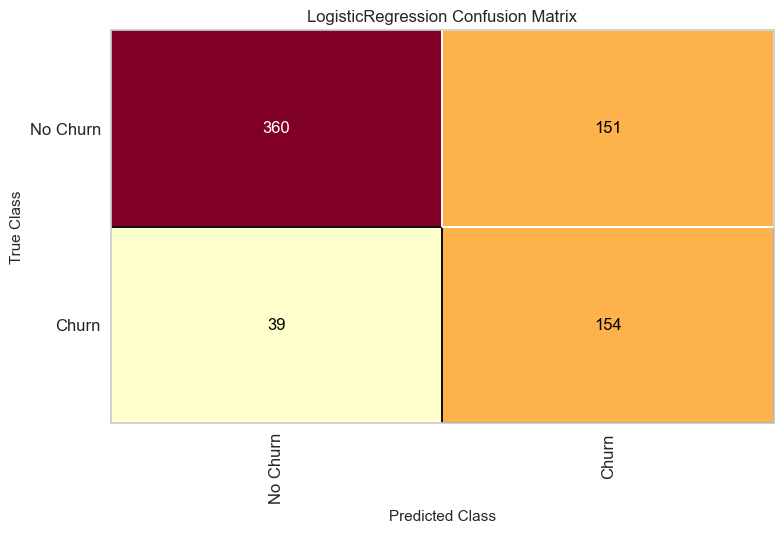

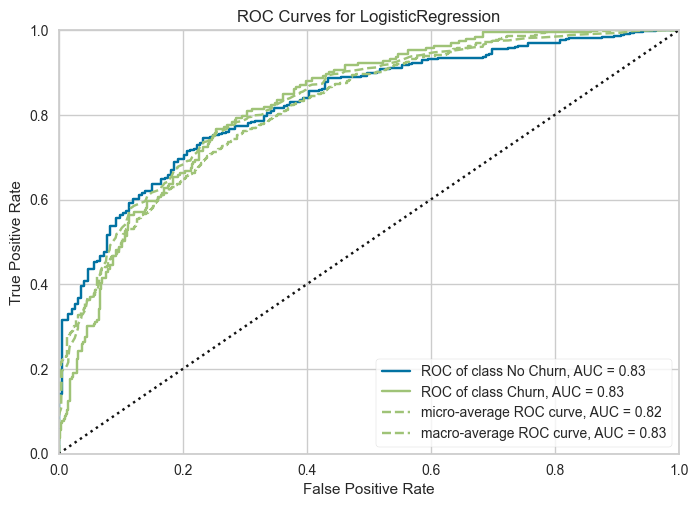

In [15]:
# Treina os modelos 
model_pipe.fit(X_train, y_train)
        
# Faz predições
y_pred = model_pipe.predict(X_valid)
 
# Validação cruzada estratificada
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        
# Validação cruzada pela métrica f1_score, (nos dados de validação/teste) 
recall = cross_val_score(model_pipe, X_valid, y_valid, scoring="recall", cv=skfold, n_jobs=-1)
 
# métrica área sob a curva de característica de operação do receptor
auc = roc_auc_score(y_valid, y_pred)
 
#Exibe as métricas 
print(f"Recall_CV:{recall.mean():.3f} STD: {recall.std():.2f}, AUC: {auc:.3f}",end="\n")
print(f'Model:{model_pipe}\n {classification_report(y_valid, y_pred)} ')

# Exibe matriz de confusão
mapping = {0:"No Churn",1:"Churn"}
confusion_matrix(
    model_pipe,
    X_train, y_train, X_valid, y_valid,
    classes=['No Churn', 'Churn'],
    label_encoder=mapping
)
plt.tight_layout()

# # Exibe curva ROC
visualizer = ROCAUC(model_pipe, classes=["No Churn", "Churn"])
visualizer.fit(X_train, y_train)        
visualizer.score(X_valid, y_valid)        
visualizer.show();

## Test

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', TargetEncoder(),
                                                  ['SeniorCitizen', 'Partner',
                                                   'Dependents',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'Payment

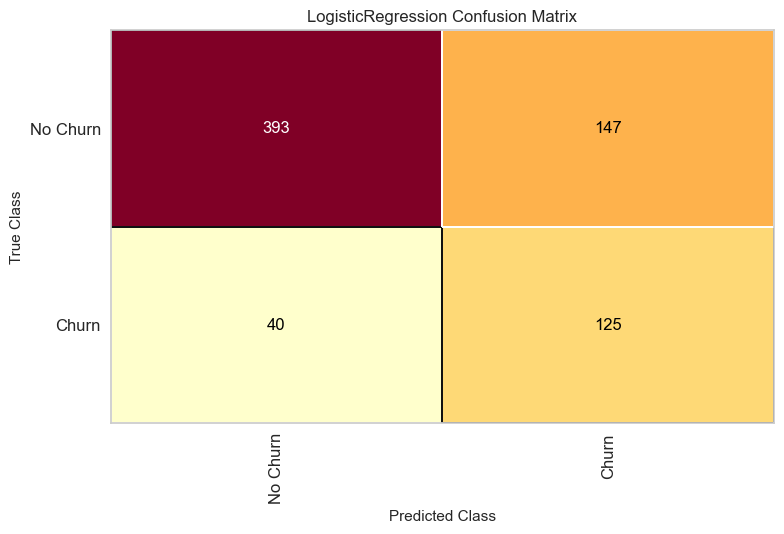

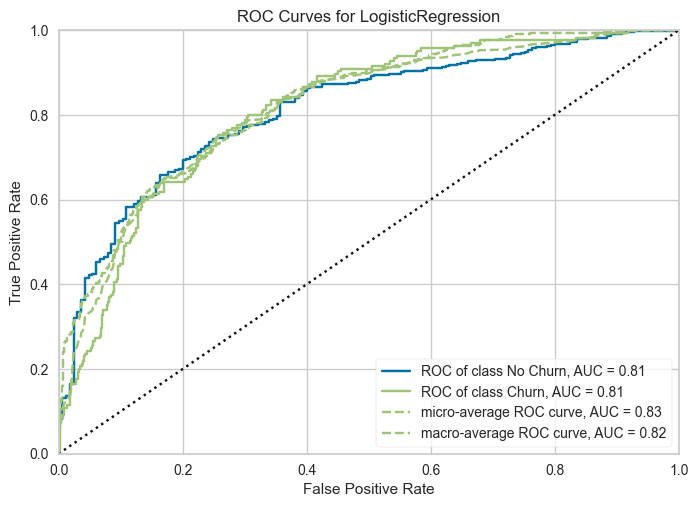

In [16]:
# Faz predições
y_pred = model_pipe.predict(X_test)
 
# métrica área sob a curva de característica de operação do receptor
auc = roc_auc_score(y_test, y_pred)
 
#Exibe as métricas 
print(f"{model_pipe}",end="\n\n")
print(f"Recall_CV:{recall.mean():.3f} STD: {recall.std():.2f}, AUC: {auc:.3f}",end="\n")
print(f'Model:{model_pipe}\n {classification_report(y_test, y_pred)} ')

# Exibe matriz de confusão
mapping = {0:"No Churn",1:"Churn"}
confusion_matrix(
    model_pipe,
    X_valid, y_valid, X_test, y_test,
    classes=['No Churn', 'Churn'],
    label_encoder=mapping
)
plt.tight_layout()

# Exibe curva ROC
visualizer = ROCAUC(model_pipe, classes=["No Churn", "Churn"])
visualizer.fit(X_valid, y_valid)        
visualizer.score(X_test, y_test)        
visualizer.show();

## Deploy

In [17]:
with open(r'C:\Users\erico\Documents\projeto-churn\Telco-Customer-Churn\models\model.pkl', 'wb') as f:
    joblib.dump(model_pipe, f)

In [18]:
with open(r'C:\Users\erico\Documents\projeto-churn\Telco-Customer-Churn\models\model.pkl', 'rb') as f:
    model = joblib.load(f)

In [19]:
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', TargetEncoder(),
                                                  ['SeniorCitizen', 'Partner',
                                                   'Dependents',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod']),
                                                 ('num', MinMaxScaler(),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges'])])),
                ('model',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    max_iter=300, random_state=42))])

In [20]:
with open(r'C:\Users\erico\Documents\projeto-churn\Telco-Customer-Churn\models\target_encoder.pkl', 'wb') as f:
    pickle.dump(le_Y, f)

In [21]:
with open(r'C:\Users\erico\Documents\projeto-churn\Telco-Customer-Churn\models\target_encoder.pkl', 'rb') as f:
    target_encoder = pickle.load(f)

In [22]:
target_encoder

LabelEncoder()